In [189]:
!pip install transformers datasets accelerate scikit-learn -q

In [190]:
import pandas as pd
import os
import numpy as np
from collections import Counter
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [191]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [192]:
BASE_PATH = "/content/drive/My Drive/PhD/Courses/year_2/text_analytics/semeval-task9"

In [193]:
folders = ['data/raw', 'data/processed', 'models', 'results/metrics', 'features']
for folder in folders:
    os.makedirs(os.path.join(BASE_PATH, folder), exist_ok=True)

In [194]:
train_en = pd.read_csv(f'{BASE_PATH}/data/raw/eng.csv')

In [195]:
train_en.head()

,id,text,polarization
0,en_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0
1,en_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0
2,en_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0
3,en_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0
4,en_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0


In [204]:
# train_en.info()     #for english its 2676 rows of training data
# train_en.isnull().sum()      #no null values

,0
id,0
text,0
polarization,0


In [197]:
train_en.shape

(2676, 3)

In [198]:
train_en.columns.tolist()

['id', 'text', 'polarization']

In [206]:
train_en['polarization'].value_counts()

,count
polarization,
0,1674
1,1002


In [207]:
train_en['polarization'].value_counts(normalize=True) * 100

,proportion
polarization,
0,62.556054
1,37.443946


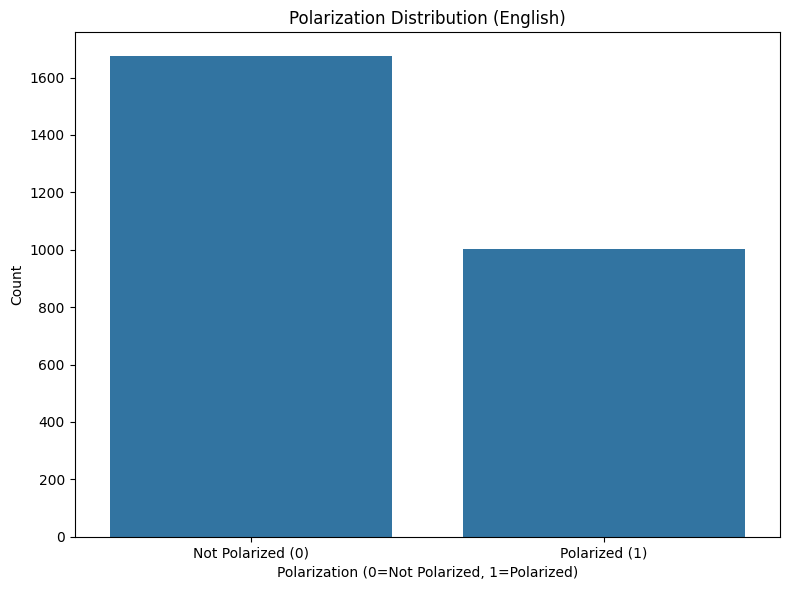

In [208]:
# Visualize
plt.figure(figsize=(8, 6))
sns.countplot(data=train_en, x='polarization')
plt.title('Polarization Distribution (English)')
plt.xlabel('Polarization (0=Not Polarized, 1=Polarized)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Polarized (0)', 'Polarized (1)'])
plt.tight_layout()
plt.show()

In [210]:
# Class imbalance ratio
counts = train_en['polarization'].value_counts()
imbalance_ratio = counts.max() / counts.min()
print(f"Class imbalance ratio: {imbalance_ratio:.2f}")

Class imbalance ratio: 1.67


In [212]:
# Text Length Analysis
train_en['text_length'] = train_en['text'].str.len()
train_en['word_count'] = train_en['text'].str.split().str.len()
train_en[['text_length', 'word_count']].describe()

,text_length,word_count
count,2676.000000,2676.000000
mean,75.671525,12.379297
std,49.809590,8.447972
min,18.000000,4.000000
25%,47.000000,7.000000
50%,57.000000,9.000000
75%,88.000000,15.000000
max,299.000000,60.000000


In [213]:
# Text stats by class
train_en.groupby('polarization')[['text_length', 'word_count']].agg(['mean', 'median', 'std'])

text_length                   word_count                 
                    mean median        std       mean median       std
polarization                                                          
0              69.464158   55.0  46.883103  11.222820    9.0  7.834583
1              86.041916   72.5  52.766655  14.311377   12.0  9.064143

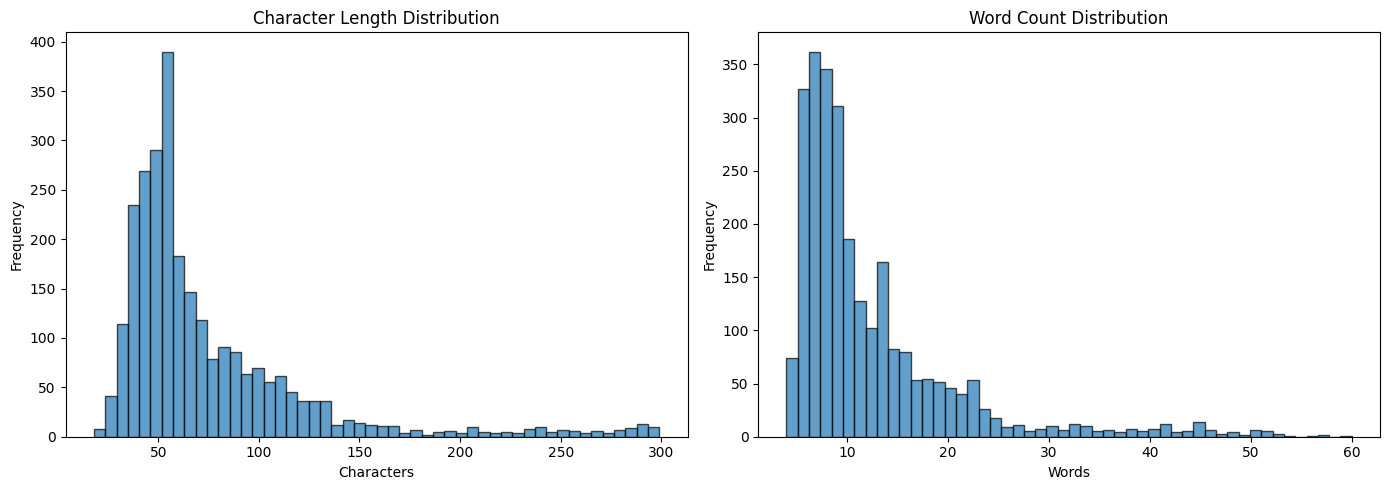

In [214]:
# Visualize text length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(train_en['text_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Character Length Distribution')
axes[0].set_xlabel('Characters')
axes[0].set_ylabel('Frequency')

axes[1].hist(train_en['word_count'], bins=50, edgecolor='black', alpha=0.7)
axes[1].set_title('Word Count Distribution')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

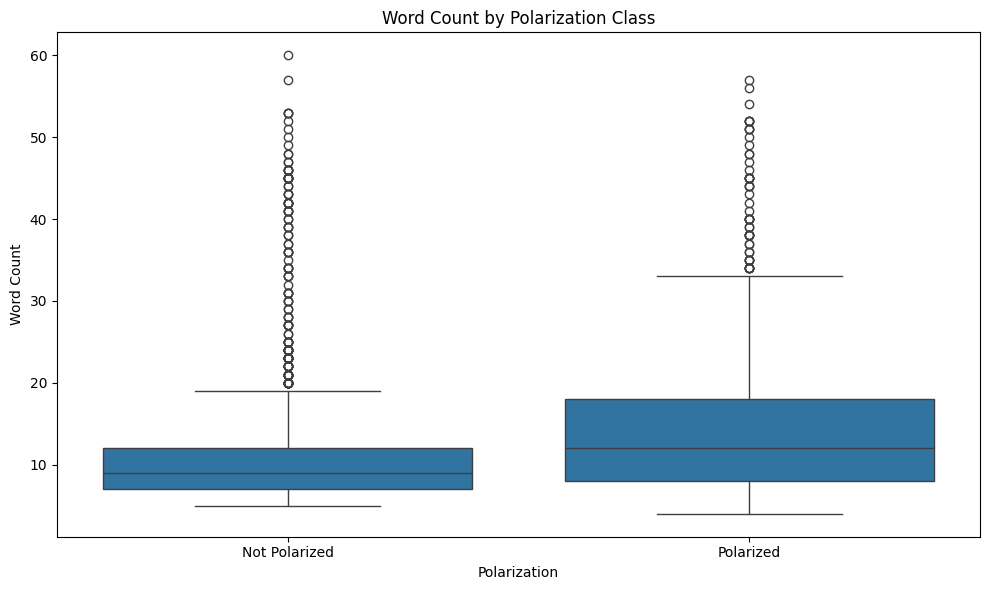

In [215]:
# Box plot by polarization class
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_en, x='polarization', y='word_count')
plt.title('Word Count by Polarization Class')
plt.xlabel('Polarization')
plt.ylabel('Word Count')
plt.xticks([0, 1], ['Not Polarized', 'Polarized'])
plt.tight_layout()
plt.show()

In [218]:
# Check for very short/long texts
# train_en[train_en['word_count'] < 5].shape[0]
train_en[train_en['word_count'] > 200].shape[0]

0

###Sample Examples


In [219]:
# Non-polarized examples
train_en[train_en['polarization'] == 0][['text']].head(5)

,text
0,is defending imperialism in the dnd chat
1,Still playing with this. I am now following Ra...
2,.senate.gov Theres 3 groups out there Republic...
3,"""ABC MD, David Anderson, said the additional f..."
4,"""bad people"" I have some conservative values s..."


In [220]:
# Polarized examples
train_en[train_en['polarization'] == 1][['text']].head(5)

,text
1674,Preemptive . . SNOWFLAKE.....
1675,speaking FACTS. Elites only care about border ...
1676,indict unrest martial law no more electoral co...
1677,its called lies and spread propaganda
1678,"""Conservative values"" okay junior. Its an oxym..."


In [221]:
# Random sample
train_en.sample(10)[['text', 'polarization']]

,text,polarization
1843,"Good, its deeply flawed, just like Zionism.",1
1455,Im becoming more and more of a west bank lover...,0
1111,There are now no NGOs on the ground in Yemen a...,0
111,Articles of impeachment. Thats what you need t...,0
871,Party for Socialism and Liberation holds demon...,0
800,My sister doesnt know how Kamala Harris is,0
744,Los Altos council meeting serves as forum on I...,0
2321,You mean voter fraud ? Thats Red.,1
2556,So the FBI contacted Facebook etc about Hunter...,1
1305,Yes! This is what I want to see on MSNBC!!,0


In [222]:
# Check for duplicates
duplicates = train_en.duplicated(subset=['text']).sum()
print(f"Duplicate texts: {duplicates}")

Duplicate texts: 0


In [227]:
# Check duplicate IDs
duplicate_ids = train_en.duplicated(subset=['id']).sum()
print(duplicate_ids)

0


In [228]:
# Check for empty texts
empty_texts = train_en['text'].isna().sum()
print(f"Empty texts: {empty_texts}")

Empty texts: 0


In [225]:
# Check text length extremes
print("Shortest text:")
print(train_en.loc[train_en['text_length'].idxmin(), 'text'])

Shortest text:
Tell it to the IDF


In [229]:
print("\nLongest text:")
print(train_en.loc[train_en['text_length'].idxmax(), 'text'])


Longest text:
GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA GAZA


In [230]:
# Quartiles for max_length decision
train_en['word_count'].quantile([0.5, 0.75, 0.90, 0.95, 0.99])

,word_count
0.50,9.0
0.75,15.0
0.90,22.0
0.95,30.0
0.99,47.0


In [231]:
# Summary statistics
summary = {
    'Total samples': len(train_en),
    'Polarized': (train_en['polarization'] == 1).sum(),
    'Not Polarized': (train_en['polarization'] == 0).sum(),
    'Avg word count': train_en['word_count'].mean(),
    'Median word count': train_en['word_count'].median(),
    'Max word count': train_en['word_count'].max(),
    'Min word count': train_en['word_count'].min()
}

pd.Series(summary)

,0
Total samples,2676.000000
Polarized,1002.000000
Not Polarized,1674.000000
Avg word count,12.379297
Median word count,9.000000
Max word count,60.000000
Min word count,4.000000


### Polarization Analysis

In [232]:
import torch
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print("✅ Training on GPU - fast!")
else:
    print("❌ Training on CPU - very slow!")

GPU available: False
❌ Training on CPU - very slow!
